# Mount google drive

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !ls /content/gdrive/MyDrive/Graph_project/

7201_dataset.csv     7201_KG_data.xlsx	    What_about_yourself.csv
7201_dataset_r1.csv  Combine_dataset.ipynb  What_about_yourself_new.csv
7201_dataset_r1.txt  gather_KG.ipynb	    wrapping_data.ipynb
7201_dataset.txt     readme.txt


In [3]:
# PATH = '/content/gdrive/MyDrive/Graph_project'

# Setup and comfig

In [4]:
!pip install ampligraph

In [5]:
!pip uninstall tensorflow
!pip install tensorflow==1.15.2

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.7.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? 
Your response ('') was not one of the expected responses: y, n
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.7.0
     |████████████████████████████████| 110.5 MB 38 kB/s 
     |████████████████████████████████| 3.8 MB 47.5 MB/s 
     |████████████████████████████████| 503 kB 73.6 MB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=15f8bf0d4f127d0bdb4774543507809face1872de9421983

In [16]:
import numpy as np
import pandas as pd
import ampligraph
import matplotlib.pyplot as plt
import seaborn as sns

from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.datasets import load_from_csv
from ampligraph.latent_features import ComplEx
from ampligraph.evaluation import evaluate_performance
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

import tensorflow as tf

# EDA

## Load dataset

In [ ]:
PATH = 'data/'

In [43]:
X = load_from_csv(PATH, '7201_dataset_r1.csv', sep=',')
X[:5,]

array([['P001', 'friend with', 'P002'],
       ['P001', 'friend with', 'P006'],
       ['P001', 'friend with', 'P008'],
       ['P001', 'friend with', 'P011'],
       ['P001', 'friend with', 'P012']], dtype=object)

In [44]:
X.shape

(1263, 3)

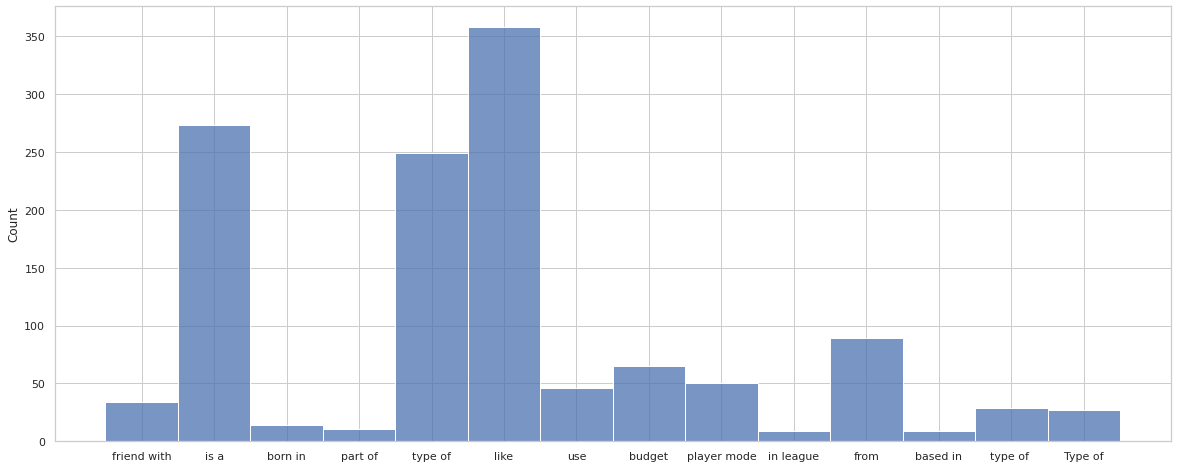

In [45]:
sns.set_theme(rc = {'figure.figsize':(20,8)},
              style="whitegrid")
sns.histplot(X[:,1])

In [46]:
type_of_lists = ['type of ', 'Type of']

for ind, val in enumerate(X):
  if val[1] in type_of_lists:
    X[ind,1] = 'type of'

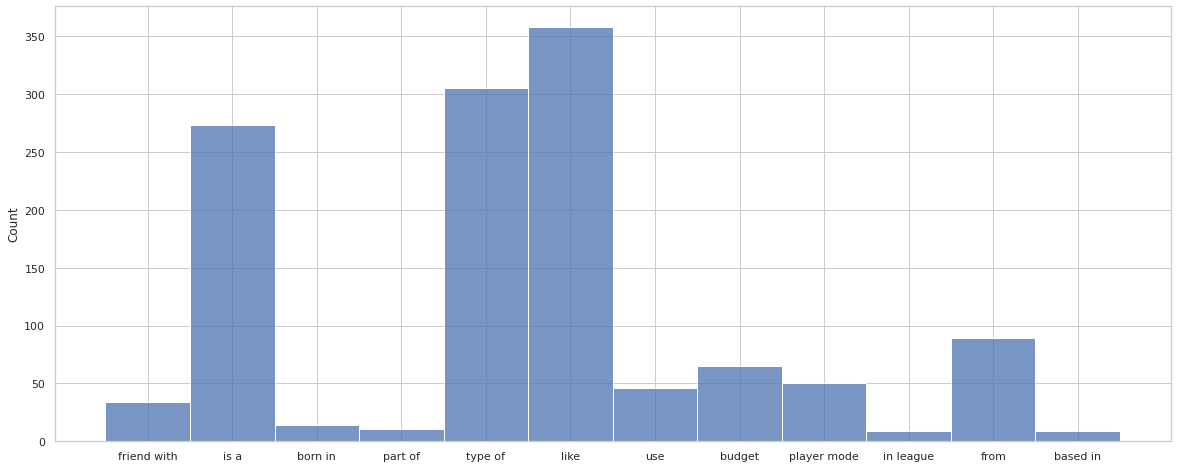

In [47]:
sns.set_theme(rc = {'figure.figsize':(20,8)},
              style="whitegrid")
sns.histplot(X[:,1])

In [48]:
num_test = int(len(X) * 0.2)

data = {}
data['train'], data['test'] = train_test_split_no_unseen(X, test_size=num_test, seed=0, allow_duplication=False) 

print('Train set size: ', data['train'].shape)
print('Test set size: ', data['test'].shape)

Train set size:  (1011, 3)
Test set size:  (252, 3)


In [49]:
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

In [50]:
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(data['train'], early_stopping = False)

Average ComplEx Loss:   0.048031: 100%|██████████| 200/200 [01:19<00:00,  2.51epoch/s]


In [51]:
positives_filter = X

In [52]:
ranks = evaluate_performance(data['test'], 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 252/252 [00:01<00:00, 203.35it/s]


In [53]:
mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.30
Hits@10: 0.55
Hits@3: 0.35
Hits@1: 0.18


In [63]:
X_unseen = np.array([
    ['P001', 'from', 'Thailand'],
    ['P003', 'from', 'Thailand'],
    ['P007', 'from', 'Thailand'],
    ['P002', 'like', 'The Secret Life of Walter Mitty'],
    ['P002', 'like', 'Star Wars'],
    ['P002', 'like', 'ID4'],
    ['P007', 'like', 'ID4'],
    ['P007', 'like', 'Star Wars'],
    ['P008', 'like', 'La La Land '],
    ['P008', 'like', 'Spirited Away']
])

In [64]:
unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))

ranks_unseen = evaluate_performance(
    X_unseen, 
    model=model, 
    filter_triples=unseen_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

scores = model.predict(X_unseen)

100%|██████████| 10/10 [00:00<00:00, 78.19it/s]


In [65]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
3,P002 like The Secret Life of Walter Mitty,729,-2.597474,0.069301
2,P007 from Thailand,807,-2.523521,0.074226
0,P001 from Thailand,755,-1.798045,0.142089
1,P003 from Thailand,676,-1.215069,0.228805
9,P008 like Spirited Away,525,-0.498095,0.377988
7,P007 like Star Wars,83,3.038534,0.954285
6,P007 like ID4,66,3.399319,0.967683
8,P008 like La La Land,71,4.040114,0.982709
5,P002 like ID4,41,6.781128,0.998866
4,P002 like Star Wars,13,8.430610,0.999782


In [122]:
X_budget = np.array([
    ['Pxxx', 'budget', 'free'],
    ['Pxxx', 'budget', 'low cost'],
    ['Pxxx', 'budget', 'medium cost'],
    ['Pxxx', 'budget', 'premium cost'],
])

for ind, val in enumerate(X_budget):
    X_budget[ind,0] = 'P001'

In [123]:
budget_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))

ranks_budget = evaluate_performance(
    X_budget, 
    model=model, 
    filter_triples=budget_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

scores = model.predict(X_unseen)

100%|██████████| 4/4 [00:00<00:00, 53.52it/s]


In [124]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in X_budget], 
                      ranks_budget, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
3,P001 budget premium cost,747,-2.597474,0.069301
2,P001 budget medium cost,573,-2.523521,0.074226
0,P001 budget free,637,-1.798045,0.142089
1,P001 budget low cost,828,-1.215069,0.228805
